## 1. Importing libraries

In [20]:
import os
import pandas as pd
import pickle

from PIL.ImImagePlugin import split

DATA_FOLDER = "/home/yeray142/Documents/projects/multimodal-exercise/data/first_Impressions_v3_multimodal"
# Get data from the folders
OUT_DATA_FOLDER = "/home/yeray142/Documents/projects/multimodal-exercise/data/dataset_v3"

## 2. Reading data

In [21]:
age_test = pd.read_csv(os.path.join(DATA_FOLDER, "test_set_age_labels.csv"))
age_train = pd.read_csv(os.path.join(DATA_FOLDER, "train_set_age_labels.csv"))
age_val = pd.read_csv(os.path.join(DATA_FOLDER, "valid_set_age_labels.csv"))

In [22]:
age_train.head()

,VideoName,UserID,AgeGroup,Gender,Ethnicity
0,YFm-8VGsUGg.004.mp4,YFm-8VGsUGg,1,2,2
1,-2qsCrkXdWs.001.mp4,-2qsCrkXdWs,1,1,2
2,rW7b48Dy_80.000.mp4,rW7b48Dy_80,1,2,2
3,1zpucNpIDk8.000.mp4,1zpucNpIDk8,1,2,3
4,2KSBoJZMcMU.000.mp4,2KSBoJZMcMU,1,1,2


In [23]:
def remove_mp4_extension(video_name):
    # Only remove .mp4 if it appears at the end of the string
    if video_name.endswith('.mp4'):
        return video_name[:-4]
    return video_name

# Apply the function to the VideoName column
age_train['VideoName'] = age_train['VideoName'].apply(remove_mp4_extension)
age_val['VideoName'] = age_val['VideoName'].apply(remove_mp4_extension)
age_test['VideoName'] = age_test['VideoName'].apply(remove_mp4_extension)

# Verify the changes
age_train['VideoName'].head()

0    YFm-8VGsUGg.004
1    -2qsCrkXdWs.001
2    rW7b48Dy_80.000
3    1zpucNpIDk8.000
4    2KSBoJZMcMU.000
Name: VideoName, dtype: object

In [24]:
test_videos = os.path.join(DATA_FOLDER, 'test')
train_videos = os.path.join(DATA_FOLDER, 'train')
validation_videos = os.path.join(DATA_FOLDER, 'valid')

The following function will be used to get the video names from the folders:

In [25]:
import shutil


# Function to extract the video name from the file path
def extract_video_name(file_path):
    # Get the filename without extension
    return os.path.splitext(os.path.basename(file_path))[0]

def get_data(src_folder, dest_folder):
    # Initialize lists to store data for the dataframe
    data = []

    # Walk through the source directory
    for root, _, files in os.walk(src_folder):
        age_group = os.path.basename(root)

        for file in files:
            file_path = os.path.join(root, file)
            video_name = extract_video_name(file)
            extension = os.path.splitext(file)[1].lower()

            # Copy jpg and wav files to destination with new names
            if extension in ['.jpg', '.wav']:
                dest_file = os.path.join(dest_folder, f"{video_name}{extension}")
                shutil.copy2(file_path, dest_file)

            # Load transcription from pickle files
            if extension == '.pkl':
                with open(file_path, 'rb') as f:
                    transcription = pickle.load(f)

                # Add entry to our data list
                data.append({
                    'VideoName': video_name,
                    'ImagePath': f"{video_name}.jpg",
                    'AudioPath': f"{video_name}.wav",
                    'Transcription': transcription,
                    'AgeGroup': age_group
                })
    return data

test_data = get_data(test_videos, os.path.join(OUT_DATA_FOLDER, 'test'))
train_data = get_data(train_videos, os.path.join(OUT_DATA_FOLDER, 'train'))
validation_data = get_data(validation_videos, os.path.join(OUT_DATA_FOLDER, 'validation'))

Let's check that all videos in the folders are in the age_dev and age_test dataframes:

In [26]:
def create_df(data, age_df):
    # Create the dataframe
    age_test_updated = pd.DataFrame(data)
    if age_df is not None:
	    age_df = age_df.merge(
            age_test_updated[['VideoName', 'ImagePath', 'AudioPath', 'Transcription']],
            on='VideoName',
            how='left'
        )
    else:
        age_df = age_test_updated
    return age_df

age_test_updated = create_df(test_data, age_test)
age_train_updated = create_df(train_data, age_train)
age_validation_updated = create_df(validation_data, age_val)

In [27]:
age_train_updated.head()

,VideoName,UserID,AgeGroup,Gender,Ethnicity,ImagePath,AudioPath,Transcription
0,YFm-8VGsUGg.004,YFm-8VGsUGg,1,2,2,YFm-8VGsUGg.004.jpg,YFm-8VGsUGg.004.wav,... occasions because whenever it gets to Chri...
1,-2qsCrkXdWs.001,-2qsCrkXdWs,1,1,2,-2qsCrkXdWs.001.jpg,-2qsCrkXdWs.001.wav,I'm thinking with how much time and energy I'm...
2,rW7b48Dy_80.000,rW7b48Dy_80,1,2,2,rW7b48Dy_80.000.jpg,rW7b48Dy_80.000.wav,... Littlest Petshops no I don't. What do I fi...
3,1zpucNpIDk8.000,1zpucNpIDk8,1,2,3,1zpucNpIDk8.000.jpg,1zpucNpIDk8.000.wav,-and eating fry. I love a good burger and chip...
4,2KSBoJZMcMU.000,2KSBoJZMcMU,1,1,2,2KSBoJZMcMU.000.jpg,2KSBoJZMcMU.000.wav,Who they say they are. I'm not basing it off s...


## 3. Mapping column names

We will rename the columns to match the ones in the metadata file for Hugging Face:

In [28]:
rename_mapping = {
	'ImagePath': 'image_file_name',
	'AudioPath': 'audio_file_name',
    'Transcription': 'transcription',
	'AgeGroup': 'age_group',
	'Gender': "gender",
	'VideoName': "video_name",
	'Ethnicity': "ethnicity",
	'UserID': "user_id"
}

age_train_updated.rename(columns=rename_mapping, inplace=True)
age_validation_updated.rename(columns=rename_mapping, inplace=True)
age_test_updated.rename(columns=rename_mapping, inplace=True)
age_train_updated.head()

,video_name,user_id,age_group,gender,ethnicity,image_file_name,audio_file_name,transcription
0,YFm-8VGsUGg.004,YFm-8VGsUGg,1,2,2,YFm-8VGsUGg.004.jpg,YFm-8VGsUGg.004.wav,... occasions because whenever it gets to Chri...
1,-2qsCrkXdWs.001,-2qsCrkXdWs,1,1,2,-2qsCrkXdWs.001.jpg,-2qsCrkXdWs.001.wav,I'm thinking with how much time and energy I'm...
2,rW7b48Dy_80.000,rW7b48Dy_80,1,2,2,rW7b48Dy_80.000.jpg,rW7b48Dy_80.000.wav,... Littlest Petshops no I don't. What do I fi...
3,1zpucNpIDk8.000,1zpucNpIDk8,1,2,3,1zpucNpIDk8.000.jpg,1zpucNpIDk8.000.wav,-and eating fry. I love a good burger and chip...
4,2KSBoJZMcMU.000,2KSBoJZMcMU,1,1,2,2KSBoJZMcMU.000.jpg,2KSBoJZMcMU.000.wav,Who they say they are. I'm not basing it off s...


Finally, let's save the dataframes to csv files:

In [29]:
age_train_updated.to_csv(f"{OUT_DATA_FOLDER}/train/metadata.csv", index=False)
age_validation_updated.to_csv(f"{OUT_DATA_FOLDER}/validation/metadata.csv", index=False)
age_test_updated.to_csv(f"{OUT_DATA_FOLDER}/test/metadata.csv", index=False)

## 5. Push to Hugging Face Hub

In [50]:
from datasets import DatasetDict, Dataset, Audio, Image
import pandas as pd
import os

data_dir = "/home/yeray142/Documents/projects/multimodal-exercise/data/dataset_v3"  # Path to your dataset root

# Load splits (train/validation/test)
splits = ["train", "validation", "test"]
dataset_dict = DatasetDict()

for split in splits:
    # Read metadata.csv for the split
    csv_path = os.path.join(data_dir, split, "metadata.csv")
    df = pd.read_csv(csv_path)

    # Add full paths to image/audio files
    df["image_path"] = df["image_file_name"].apply(
        lambda x: os.path.join(data_dir, split, x)
    )
    df["audio_path"] = df["audio_file_name"].apply(
        lambda x: os.path.join(data_dir, split, x)
    )

    # Create a Dataset from the DataFrame
    dataset = Dataset.from_pandas(df)
    dataset_dict[split] = dataset

# Cast columns to Image/Audio to auto-decode files
dataset_dict = dataset_dict.cast_column("image_path", Image())
dataset_dict = dataset_dict.cast_column("audio_path", Audio())

[ 6.07299805e-03 -6.10351562e-04  5.18798828e-03 ...  3.05175781e-05
  0.00000000e+00  0.00000000e+00] 8000


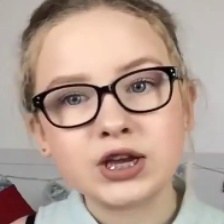

In [57]:
example = dataset_dict["train"][0]

# Audio (dict with array and sampling_rate)
audio = example["audio_path"]
print(audio["array"], audio["sampling_rate"])

example["image_path"]

In [59]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['video_name', 'user_id', 'age_group', 'gender', 'ethnicity', 'image_file_name', 'audio_file_name', 'transcription', 'image_path', 'audio_path'],
        num_rows: 6011
    })
    validation: Dataset({
        features: ['video_name', 'user_id', 'age_group', 'gender', 'ethnicity', 'image_file_name', 'audio_file_name', 'transcription', 'image_path', 'audio_path'],
        num_rows: 2019
    })
    test: Dataset({
        features: ['video_name', 'user_id', 'age_group', 'gender', 'ethnicity', 'image_file_name', 'audio_file_name', 'transcription', 'image_path', 'audio_path'],
        num_rows: 1975
    })
})

In [62]:
dataset_dict['validation'][0]["audio_path"]

{'path': '/home/yeray142/Documents/projects/multimodal-exercise/data/dataset_v3/validation/syAUKJMQWeo.001.wav',
 'array': array([-3.43017578e-02, -3.75366211e-02, -2.57263184e-02, ...,
        -9.15527344e-05, -1.22070312e-04, -1.52587891e-04]),
 'sampling_rate': 8000}

In [ ]:
from huggingface_hub import HfApi
api = HfApi()

api.upload_large_folder(
    folder_path="/home/yeray142/Documents/projects/multimodal-exercise/data/dataset_v3",
    repo_id="yeray142/first-impressions-v3",
    repo_type="dataset",
)

In [15]:
from datasets import load_dataset

# Specify the data_files parameter to explicitly define the paths for each split
dataset = load_dataset(
    "yeray142/first-impressions-v3"
)

Resolving data files:   0%|          | 0/9860 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/4039 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3951 [00:00<?, ?it/s]

ValueError: Couldn't infer the same data file format for all splits. Got {NamedSplit('train'): ('imagefolder', {}), NamedSplit('validation'): ('audiofolder', {}), NamedSplit('test'): ('audiofolder', {})}